# Main Notebook for deep-icc

All cells up to **Model Setup** must be run for model training to work.

# Environment Setup

In [ ]:
# !pip uninstall --yes --quiet osqp
# !pip install scikit-survival

In [1]:
from typing import Any, Dict, Iterable, Sequence, Tuple, Optional, Union
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path
from skimage.transform import resize
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import concordance_index_censored
import tensorflow as tf
import tensorflow.compat.v2.summary as summary
from tensorflow.python.ops import summary_ops_v2
from tqdm import tqdm

# Importing my own function from external file
from patient_data_split import pat_train_test_split

# Functions
This code is adapted from Sebastian Pölsterl's tutorial on Survival Analysis for Deep Learning Tutorial for TensorFlow 2 https://k-d-w.org/blog/2019/07/survival-analysis-for-deep-learning/

In [2]:
def _make_riskset(time: np.ndarray) -> np.ndarray:
    """Compute mask that represents each sample's risk set.

    Parameters
    ----------
    time : np.ndarray, shape=(n_samples,)
        Observed event time sorted in descending order.

    Returns
    -------
    risk_set : np.ndarray, shape=(n_samples, n_samples)
        Boolean matrix where the `i`-th row denotes the
        risk set of the `i`-th instance, i.e. the indices `j`
        for which the observer time `y_j >= y_i`.
    """
    assert time.ndim == 1, "expected 1D array"

    # sort in descending order
    o = np.argsort(-time, kind="mergesort")
    
    # Initialize risk set 
    n_samples = len(time)
    risk_set = np.zeros((n_samples, n_samples), dtype=np.bool_)
    
    for i_org, i_sort in enumerate(o):
        ti = time[i_sort]
        k = i_org
        while k < n_samples and ti == time[o[k]]:
            k += 1
        risk_set[i_sort, o[:k]] = True
    return risk_set


class InputFunction:
    """Callable input function that computes the risk set for each batch.
    
    Parameters
    ----------
    images : np.ndarray, shape=(n_samples, height, width)
        Image data.
    time : np.ndarray, shape=(n_samples,)
        Observed time.
    event : np.ndarray, shape=(n_samples,)
        Event indicator.
    batch_size : int, optional, default=64
        Number of samples per batch.
    drop_last : int, optional, default=False
        Whether to drop the last incomplete batch.
    shuffle : bool, optional, default=False
        Whether to shuffle data.
    seed : int, optional, default=89
        Random number seed.
    """

    def __init__(self,
                 images: np.ndarray,
                 time: np.ndarray,
                 event: np.ndarray,
                 batch_size: int = 64,
                 drop_last: bool = False,
                 shuffle: bool = False,
                 seed: int = 89) -> None:
        # If image is 3D, reduce dimension to 2D
        if images.ndim == 3:
            images = images[..., np.newaxis]
        self.images = images
        self.time = time
        self.event = event
        self.batch_size = batch_size
        self.drop_last = drop_last
        self.shuffle = shuffle
        self.seed = seed

    def size(self) -> int:
        """Total number of samples."""
        return self.images.shape[0]

    def steps_per_epoch(self) -> int:
        """Number of batches for one epoch."""
        return int(np.floor(self.size() / self.batch_size))

    def _get_data_batch(self, index: np.ndarray) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
        """Compute risk set for samples in batch.
        
        Args:
            index - indices for the batch

        Returns:
            images - numpy array of images in the batch
            labels - dictionary of tuples (str, numpy array) with event, time, and riskset labels
        
        """
        time = self.time[index]
        event = self.event[index]
        images = self.images[index]

        # Create dictionary of labels for the batch samples
        labels = {
            "label_event": event.astype(np.int32),
            "label_time": time.astype(np.float32),
            "label_riskset": _make_riskset(time)
        }
        return images, labels

    def _iter_data(self) -> Iterable[Tuple[np.ndarray, Dict[str, np.ndarray]]]:
        """Generator that yields one batch at a time."""
        index = np.arange(self.size())
        rnd = np.random.RandomState(self.seed)

        if self.shuffle:
            rnd.shuffle(index)
        for b in range(self.steps_per_epoch()):
            start = b * self.batch_size
            idx = index[start:(start + self.batch_size)]
            yield self._get_data_batch(idx)

        if not self.drop_last:
            start = self.steps_per_epoch() * self.batch_size
            idx = index[start:]
            yield self._get_data_batch(idx)

    def _get_shapes(self) -> Tuple[tf.TensorShape, Dict[str, tf.TensorShape]]:
        """Return shapes of data returned by `self._iter_data`.
        
        Returns:
            images - tf.TensorShape, shape specification for images
            labels - dictionary of (str, tf.TensorShape), shape specification for labels
        """
        batch_size = self.batch_size if self.drop_last else None
        h, w, c = self.images.shape[1:]
        images = tf.TensorShape([batch_size, h, w, c])

        labels = {k: tf.TensorShape((batch_size,))
                  for k in ("label_event", "label_time")}
        labels["label_riskset"] = tf.TensorShape((batch_size, batch_size))
        return images, labels

    def _get_dtypes(self) -> Tuple[tf.DType, Dict[str, tf.DType]]:
        """Return dtypes of data returned by `self._iter_data`."""
        labels = {"label_event": tf.int32,
                  "label_time": tf.float32,
                  "label_riskset": tf.bool}
        return tf.float32, labels

    def _make_dataset(self) -> tf.data.Dataset:
        """Create dataset from generator."""
        ds = tf.data.Dataset.from_generator(
            self._iter_data,
            self._get_dtypes(),
            self._get_shapes()
        )
        return ds

    def __call__(self) -> tf.data.Dataset:
        return self._make_dataset()


def safe_normalize(x: tf.Tensor) -> tf.Tensor:
    """Normalize risk scores to avoid exp underflowing.

    Note that only risk scores relative to each other matter.
    If minimum risk score is negative, we shift scores so minimum
    is at zero.
    """
    x_min = tf.reduce_min(x, axis=0)
    c = tf.zeros_like(x_min)
    norm = tf.where(x_min < 0, -x_min, c)
    return x + norm


def logsumexp_masked(risk_scores: tf.Tensor,
                     mask: tf.Tensor,
                     axis: int = 0,
                     keepdims: Optional[bool] = None) -> tf.Tensor:
    """Compute logsumexp across `axis` for entries where `mask` is true.
    
    Args:
        risk_scores - tf.Tensor of predicted outputs of CoxPH, must be 2D
        mask - numpy array of boolean values with risk sets in rows, shape = (n_samples, n_samples)
        axis - int indicating which axis to perform sum across, should be axis samples is on (?)
        keepdims - bool, wheter to retain reduced dimensions in calculations
    
    Return:
        output - tf.Tensor logsumexp for risk scores
    """
    risk_scores.shape.assert_same_rank(mask.shape)

    with tf.name_scope("logsumexp_masked"):
        mask_f = tf.cast(mask, risk_scores.dtype)
        risk_scores_masked = tf.math.multiply(risk_scores, mask_f)
        # for numerical stability, substract the maximum value
        # before taking the exponential
        amax = tf.reduce_max(risk_scores_masked, axis=axis, keepdims=True)
        risk_scores_shift = risk_scores_masked - amax

        exp_masked = tf.math.multiply(tf.exp(risk_scores_shift), mask_f)
        exp_sum = tf.reduce_sum(exp_masked, axis=axis, keepdims=True)
        output = amax + tf.math.log(exp_sum)
        if not keepdims:
            output = tf.squeeze(output, axis=axis)
    return output


class CoxPHLoss(tf.keras.losses.Loss):
    """Negative partial log-likelihood of Cox's proportional hazards model."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)            

    def call(self,
             y_true: Sequence[tf.Tensor],
             y_pred: tf.Tensor) -> tf.Tensor:
        """Compute loss.

        Parameters
        ----------
        y_true : list|tuple of tf.Tensor
            The first element holds a binary vector where 1
            indicates an event and 0 indicates censoring.
            The second element holds the riskset, a
            boolean matrix where the `i`-th row denotes the
            risk set of the `i`-th instance, i.e. the indices `j`
            for which the observer time `y_j >= y_i`.
            Both must be rank 2 tensors.
        y_pred : tf.Tensor
            The predicted outputs. Must be a rank 2 tensor.

        Returns
        -------
        loss : tf.Tensor
            Loss for each instance in the batch.
        """
        event, riskset = y_true
        predictions = y_pred

        # Input checking
        pred_shape = predictions.shape
        if pred_shape.ndims != 2:
            raise ValueError("Rank mismatch: Rank of predictions (received %s) should "
                             "be 2." % pred_shape.ndims)

        if pred_shape[1] is None:
            raise ValueError("Last dimension of predictions must be known.")

        if pred_shape[1] != 1:
            raise ValueError("Dimension mismatch: Last dimension of predictions "
                             "(received %s) must be 1." % pred_shape[1])

        if event.shape.ndims != pred_shape.ndims:
            raise ValueError("Rank mismatch: Rank of predictions (received %s) should "
                             "equal rank of event (received %s)" % (
                pred_shape.ndims, event.shape.ndims))

        if riskset.shape.ndims != 2:
            raise ValueError("Rank mismatch: Rank of riskset (received %s) should "
                             "be 2." % riskset.shape.ndims)

        event = tf.cast(event, predictions.dtype)
        # Normalize risk scores
        predictions = safe_normalize(predictions)

        # More input checking
        with tf.name_scope("assertions"):
            assertions = (
                tf.debugging.assert_less_equal(event, 1.),
                tf.debugging.assert_greater_equal(event, 0.),
                tf.debugging.assert_type(riskset, tf.bool)
            )

        # move batch dimension to the end so predictions get broadcast
        # row-wise when multiplying by riskset
        pred_t = tf.transpose(predictions)
        # compute log of sum over risk set for each row
        rr = logsumexp_masked(pred_t, riskset, axis=1, keepdims=True)
        assert rr.shape.as_list() == predictions.shape.as_list()

        losses = tf.math.multiply(event, rr - predictions)

        return losses
    

class CindexMetric:
    """Computes concordance index across one epoch."""

    def reset_states(self) -> None:
        """Clear the buffer of collected values."""
        self._data = {
            "label_time": [],
            "label_event": [],
            "prediction": []
        }

    def update_state(self, y_true: Dict[str, tf.Tensor], y_pred: tf.Tensor) -> None:
        """Collect observed time, event indicator and predictions for a batch.

        Parameters
        ----------
        y_true : dict
            Must have two items:
            `label_time`, a tensor containing observed time for one batch,
            and `label_event`, a tensor containing event indicator for one batch.
        y_pred : tf.Tensor
            Tensor containing predicted risk score for one batch.
        """
        self._data["label_time"].append(y_true["label_time"].numpy())
        self._data["label_event"].append(y_true["label_event"].numpy())
        self._data["prediction"].append(tf.squeeze(y_pred).numpy())

    def result(self) -> Dict[str, float]:
        """Computes the concordance index across collected values.

        Returns
        ----------
        metrics : dict
            Computed metrics.
        """
        data = {}
        for k, v in self._data.items():
            data[k] = np.concatenate(v)

        results = concordance_index_censored(
            data["label_event"] == 1,
            data["label_time"],
            data["prediction"])

        result_data = {}
        names = ("cindex", "concordant", "discordant", "tied_risk")
        for k, v in zip(names, results):
            result_data[k] = v

        return result_data

## Model Training Functions

In [3]:
class TrainAndEvaluateModel:
    """Model with train and evaluate functions for deep survival analysis
    
    Parameters
    ----------
    model : tf.keras Model, model to train
    model_dir : pathlib.PosixPat, Directory to store training checkpoints
    train_dataset : InputFunction, training data set up with InputFunction class
    eval_dataset : InputFunction, validation data set up with InputFunction class
    learning_rate: float, learning rate to set optimizer with
    num_epochs: int, number of training epochs to run
    """

    def __init__(self, model, model_dir, train_dataset, eval_dataset,
                 learning_rate, num_epochs):
        self.num_epochs = num_epochs
        self.model_dir = model_dir

        self.model = model

        self.train_ds = train_dataset
        self.val_ds = eval_dataset

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        # self.optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
        self.loss_fn = CoxPHLoss()

        self.train_loss_metric = tf.keras.metrics.Mean(name="train_loss")
        self.val_loss_metric = tf.keras.metrics.Mean(name="val_loss")
        self.val_cindex_metric = CindexMetric()

    @tf.function
    def train_one_step(self, x, y_event, y_riskset):
        y_event = tf.expand_dims(y_event, axis=1)
        with tf.GradientTape() as tape:
            # pass input through the model
            logits = self.model(x, training=True)
            # caclulate CPH loss
            train_loss = self.loss_fn(y_true=[y_event, y_riskset], y_pred=logits)

        # calculate gradient for weight update 
        with tf.name_scope("gradients"):
            grads = tape.gradient(train_loss, self.model.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        return train_loss, logits

    def train_and_evaluate(self):
        '''Main training function to call with model.'''
        
        # Set up training checkpoints for saving the model
        ckpt = tf.train.Checkpoint(
            step=tf.Variable(0, dtype=tf.int64),
            optimizer=self.optimizer,
            model=self.model)
        ckpt_manager = tf.train.CheckpointManager(
            ckpt, str(self.model_dir), max_to_keep=2)

        if ckpt_manager.latest_checkpoint:
            ckpt.restore(ckpt_manager.latest_checkpoint)
            print(f"Latest checkpoint restored from {ckpt_manager.latest_checkpoint}.")

        train_summary_writer = summary.create_file_writer(
            str(self.model_dir / "train"))
        val_summary_writer = summary.create_file_writer(
            str(self.model_dir / "valid"))

        # beginning training
        for epoch in range(self.num_epochs):
            with train_summary_writer.as_default():
                self.train_one_epoch(ckpt.step)

            # Run a validation loop at the end of each epoch.
            with val_summary_writer.as_default():
                self.evaluate(ckpt.step)

        save_path = ckpt_manager.save()
        print(f"Saved checkpoint for step {ckpt.step.numpy()}: {save_path}")

    def train_one_epoch(self, step_counter):
        for x, y in self.train_ds:
            train_loss, logits = self.train_one_step(
                x, y["label_event"], y["label_riskset"])

            step = int(step_counter)
            if step == 0:
                # see https://stackoverflow.com/questions/58843269/display-graph-using-tensorflow-v2-0-in-tensorboard
                func = self.train_one_step.get_concrete_function(
                    x, y["label_event"], y["label_riskset"])
                summary_ops_v2.graph(func.graph, step=0)

            # Update training metric.
            self.train_loss_metric.update_state(train_loss)

            # Log every 200 batches.
            if step % 200 == 0:
                # Display metrics
                mean_loss = self.train_loss_metric.result()
                print(f"step {step}: mean loss = {mean_loss:.4f}")
                # save summaries
                summary.scalar("loss", mean_loss, step=step_counter)
                # Reset training metrics
                self.train_loss_metric.reset_states()

            step_counter.assign_add(1)

    @tf.function
    def evaluate_one_step(self, x, y_event, y_riskset):
        y_event = tf.expand_dims(y_event, axis=1)
        val_logits = self.model(x, training=False)
        val_loss = self.loss_fn(y_true=[y_event, y_riskset], y_pred=val_logits)
        return val_loss, val_logits

    def evaluate(self, step_counter):
        self.val_cindex_metric.reset_states()
        
        for x_val, y_val in self.val_ds:
            val_loss, val_logits = self.evaluate_one_step(
                x_val, y_val["label_event"], y_val["label_riskset"])

            # Update val metrics
            self.val_loss_metric.update_state(val_loss)
            self.val_cindex_metric.update_state(y_val, val_logits)

        val_loss = self.val_loss_metric.result()
        summary.scalar("loss",
                       val_loss,
                       step=step_counter)
        self.val_loss_metric.reset_states()
        
        val_cindex = self.val_cindex_metric.result()
        for key, value in val_cindex.items():
            summary.scalar(key, value, step=step_counter)

        print(f"Validation: loss = {val_loss:.4f}, cindex = {val_cindex['cindex']:.4f}")

# iCCA Data Loading

In [4]:
# Constants for development
FILESTOLOAD = 100 # 2888 is all of them
imdim_from_preprocessing = 256 # must match opt.ImageSize in image preprocessing configuration files
train_valid_split = 0.8 # where to split data for training and validation
random_seed = 16 # used in train-validation splitting
dropout_seed = 16 # used in dropout layers in kt_model

In [5]:
# Path to CSVs that connect patient id to slices and rfs label
# Mac path
# zero_info_path = "/Users/katyscott/Documents/ICC/Data/Labels/" + str(imdim_from_preprocessing) +"/RFS_all_tumors_zero.csv"
# Linux path 
zero_info_path = "/media/katy/Data/ICC/Data/Labels/RFS_all_tumors_zero.csv"

# Reading in info for zero background images
info = pd.read_csv(zero_info_path)
image_fnames = np.asarray(info.iloc[:, 0])
pat_num = np.asarray(info.iloc[:, 1])
slice_num = np.asarray(info.iloc[:, 2])
rfs_event = np.asarray(info.iloc[:, 3])
rfs_time = np.asarray(info.iloc[:, 4])

# Confirming loading in happened correctly
print("Total label count (should be 2888):", rfs_event.shape)
print("First RFS time label (should be 0.6):", rfs_time[0])

Total label count (should be 2888): (2888,)
First RFS time label (should be 0.6): 0.6


### Loading images:

  3%|▎         | 100/2888 [00:00<00:16, 170.51it/s]


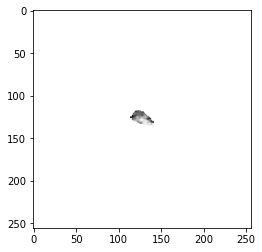

In [6]:
# Path to zero background image files
# Mac path
# zero_image_path = '/Users/katyscott/Documents/ICC/Data/Images/Tumors/' + str(imdim_from_preprocessing) + '/Zero/'

# Linux path
zero_image_path = '/media/katy/Data/ICC/Data/Images/Tumors/' + str(imdim_from_preprocessing) + '/Zero/'

images = np.empty((1,imdim_from_preprocessing,imdim_from_preprocessing))
file_count = 0
for image_file in tqdm(image_fnames):
    if file_count >= FILESTOLOAD:
        break
    else:
        file_count += 1
    #     print("Loading: ", image_file)
        # Load in file as an numpy array
        img = np.fromfile(zero_image_path + image_file)
        # Reshape image from 1D to 2D array
        img_2D = np.reshape(img, (imdim_from_preprocessing,imdim_from_preprocessing))
        # Add third dimension so image can be added to main images array
        img_final_3D = np.reshape(img_2D, (1,) + img_2D.shape)
        images = np.append(images, img_final_3D, axis=0)

images = np.delete(images, 0, axis=0)

# Confirming images loaded in properly
plt.imshow(images[0], cmap='Greys')

### Split data into training and validation sets:

In [7]:
# Splitting samples by patient and censoring code
train_slice_indices, val_slice_indices = pat_train_test_split(pat_num[:FILESTOLOAD], rfs_event[:FILESTOLOAD], train_valid_split, random_seed)

# Get training images
train_slices = images[train_slice_indices,:,:]#[:][:]
train_slices = train_slices.squeeze() # Remove first dim of size 1

# Get training labels
train_time = rfs_time[train_slice_indices]
train_event = rfs_event[train_slice_indices]
print("Training set: ", train_slices.shape)
print("Training time labels: ", train_time.shape)
print("Training event labels: ", train_event.shape)

# Get validation images
val_slices = images[val_slice_indices,:,:]
val_slices = val_slices.squeeze() # Remove first dim of size 1

# Get validation labels
val_time = rfs_time[val_slice_indices]
val_event = rfs_event[val_slice_indices]
print("Validation set: ", val_slices.shape)
print("Validation time labels: ", val_time.shape)
print("Validation event labels: ", val_event.shape)

Training set:  (73, 256, 256)
Training time labels:  (73,)
Training event labels:  (73,)
Validation set:  (27, 256, 256)
Validation time labels:  (27,)
Validation event labels:  (27,)


# Model Setup

## Polsterl tutorial model

In [1]:
# Set up model layers
polsterl_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, kernel_size=(5, 5), activation='relu', name='conv_1'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(16, (5, 5), activation='relu', name='conv_2'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu', name='dense_1'),
    tf.keras.layers.Dense(84, activation='relu', name='dense_2'),
    tf.keras.layers.Dense(1, activation='linear', name='dense_3')
])

# Set up training and validation inputs for network
polsterl_train_fn = InputFunction(train_slices, train_time, train_event,
                  drop_last=False,
                  shuffle=True)

polsterl_val_fn = InputFunction(val_slices, val_time, val_event)

polsterl_trainer = TrainAndEvaluateModel(
    model=polsterl_model,
    model_dir=Path("ckpts-polsterl-100"),
    train_dataset=polsterl_train_fn(),
    eval_dataset=polsterl_val_fn(),
    learning_rate=0.0003,
    num_epochs=100,
)

polsterl_trainer.train_and_evaluate()

NameError: name 'tf' is not defined

# DeepConvSurv model
X. Zhu, J. Yao, and J. Huang. “Deep convolutional neural network for survival analysiswith pathological images”. In:2016 IEEE International Conference on Bioinformatics andBiomedicine (BIBM). 2016, pp. 544–547.DOI:10.1109/BIBM.2016.7822579.7

Code adapted from: https://github.com/vanAmsterdam/deep-survival/blob/master/DeepConvSurv.py

In [ ]:
# Set up model layers
dcs_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(7, 7), strides = 3, activation='relu', name='conv_1'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides = 2, activation='relu', name='conv_2'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides = 2, activation='relu', name='conv_3'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu', name='dense_1'),
    tf.keras.layers.Dense(1, activation='linear', name='dense_3')
])

# Set up training and validation inputs for network
dcs_train_fn = InputFunction(train_slices, train_time, train_event,
                  batch_size=128,
                  drop_last=False,
                  shuffle=True)

dcs_val_fn = InputFunction(val_slices, val_time, val_event)

dcs_trainer = TrainAndEvaluateModel(
    model=dcs_model,
    model_dir=Path("ckpts-dcs-200"),
    train_dataset=dcs_train_fn(),
    eval_dataset=dcs_val_fn(),
    learning_rate=0.0003,
    num_epochs=200,
)

dcs_trainer.train_and_evaluate()

## KT6 model

In [8]:
# Set up model layers
kt_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(7, 7), strides = 3, activation='selu', name='conv_1'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool_1'),
    tf.keras.layers.Dropout(0.7, seed=dropout_seed, name='drop_1'),
    tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides = 2, activation='selu', name='conv_2'),
    tf.keras.layers.Dropout(0.5, seed=dropout_seed, name='drop_2'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides = 2, activation='selu', name='conv_3'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool_2'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='selu', name='dense_1'),
    tf.keras.layers.Dense(1, activation='linear', name='dense_2')
])

# Set up training and validation inputs for network
kt_train_fn = InputFunction(train_slices, train_time, train_event,
                  batch_size=64,
                  drop_last=False,
                  shuffle=True)

kt_val_fn = InputFunction(val_slices, val_time, val_event)

kt_trainer = TrainAndEvaluateModel(
    model=kt_model,
    model_dir=Path("ckpts-kt6-cnn-100"),
    train_dataset=kt_train_fn(),
    eval_dataset=kt_val_fn(),
    learning_rate=0.0003,
    num_epochs=100,
)

kt_trainer.model.build((None, 256, 256, 1))
kt_trainer.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 84, 84, 32)        1600      
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 42, 42, 32)        0         
_________________________________________________________________
drop_1 (Dropout)             (None, 42, 42, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 19, 19, 32)        25632     
_________________________________________________________________
drop_2 (Dropout)             (None, 19, 19, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 9, 9, 32)          9248      
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 4, 4, 32)          0

In [27]:
kt_trainer.train_and_evaluate() # kt6-100 run

step 0: mean loss = 26.1056
Validation: loss = 3.3270, cindex = 0.5287
Validation: loss = 3.1398, cindex = 0.5249
Validation: loss = 3.0728, cindex = 0.5119
Validation: loss = 3.0167, cindex = 0.5319
Validation: loss = 2.9838, cindex = 0.5204
step 200: mean loss = 5.3442
Validation: loss = 2.9536, cindex = 0.5160
Validation: loss = 2.9455, cindex = 0.5183
Validation: loss = 2.9313, cindex = 0.5212
Validation: loss = 2.9274, cindex = 0.5206
Validation: loss = 2.9212, cindex = 0.5187
step 400: mean loss = 2.8224
Validation: loss = 2.9193, cindex = 0.5186
Validation: loss = 2.9163, cindex = 0.5191
Validation: loss = 2.9172, cindex = 0.5178
Validation: loss = 2.9179, cindex = 0.5203
Validation: loss = 2.9171, cindex = 0.5203
step 600: mean loss = 2.6971
Validation: loss = 2.9171, cindex = 0.5214
Validation: loss = 2.9146, cindex = 0.5184
Validation: loss = 2.9181, cindex = 0.5196
Validation: loss = 2.9191, cindex = 0.5209
Validation: loss = 2.9175, cindex = 0.5193
step 800: mean loss = 2.6

### Training output visualization

In [28]:
# Load the Tensorboard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [116]:
# Set path to tensorboard installation in virtual environment
os.environ['TENSORBOARD_BINARY']='/Users/katyscott/Documents/ICC/venv/bin/tensorboard'

%tensorboard --logdir ckpts-kt6-cnn-100

Reusing TensorBoard on port 6007 (pid 5663), started 2 days, 21:25:17 ago. (Use '!kill 5663' to kill it.)